# Classifying Fashion MNIST dataset

importing libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

Downloading training and test dataset of FashionMNIST

In [2]:
train_dataset = FashionMNIST(root='data/FashionMNIST/train/',train=True, transform=ToTensor(),download=True)
test_dataset = FashionMNIST(root='data/FashionMNIST/test/',train=False, transform=ToTensor(),download=True)

In [3]:
len(train_dataset),len(test_dataset)

(60000, 10000)

Listing all catagories

In [4]:
print(train_dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


visualizing images

image.shape : torch.Size([1, 28, 28])
Label : Ankle boot, 9


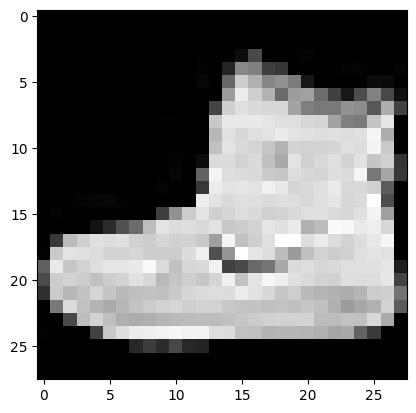

In [5]:
image, label = train_dataset[0]
print(f'image.shape : {image.shape}')
plt.imshow(image.permute(1,2,0),cmap='gray')
print(f'Label : {train_dataset.classes[label]}, {label}')

image.shape : torch.Size([1, 28, 28])
Label : Pullover, 2


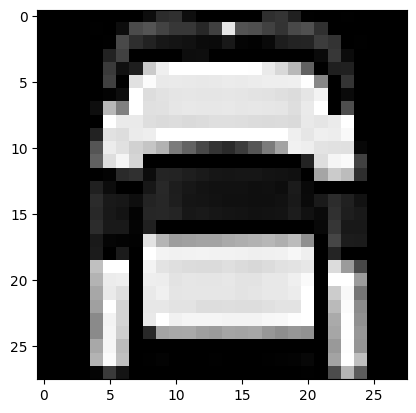

In [6]:
image, label = train_dataset[125]
print(f'image.shape : {image.shape}')
plt.imshow(image.permute(1,2,0),cmap='gray')
print(f'Label : {train_dataset.classes[label]}, {label}')

making validation set

In [7]:
val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(50000, 10000)

Creating PyTorch data loaders for training and validation

In [8]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

grid visualizing of images

images.shape : torch.Size([128, 1, 28, 28])


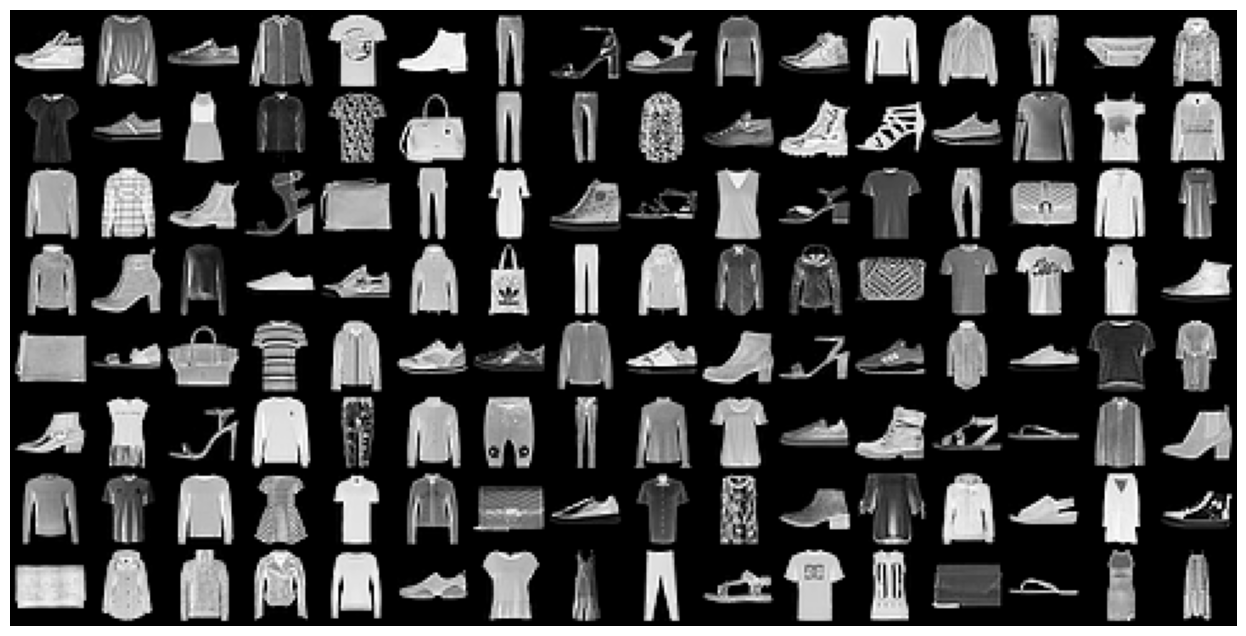

In [9]:
for images,_ in train_loader:
    print(f'images.shape : {images.shape}')
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

# Model

In [10]:
def accuracy(outputs, label):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==label).item()/len(preds))

In [11]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out,labels)  # Calculate loss

        return loss

    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # calculate accuracy

        return {'val_loss' : loss, 'val_acc' : acc}
    
    def validation_epoch_end(slef, outputs):
        batch_losses = []
        batch_accs = []

        for x in outputs:
            batch_losses.append(x['val_loss'])
            batch_accs.append(x['val_acc'])

        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        epoch_acc = torch.stack(batch_accs).mean()      # combine accuracies

        return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()} 
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], val_loss : {result['val_loss']}, val_acc : {result['val_acc']}")

In [12]:
class FashionMNIST(ImageClassificationBase):
    def __init__(self,in_size, out_size, hidden_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2,out_size)
        )
    
    def forward(self, xb):
        xb = xb.view(xb.size(0),-1)
        out = self.network(xb)

        return out

Create a model with hidden layers of 32 and 64

In [13]:
input_size = 784
hidden_size = 32
num_classes = 10

In [14]:
model = FashionMNIST(input_size, num_classes, hidden_size)

In [15]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([64, 32])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


Using a GPU if availaible

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def to_device(data, device):
    if isinstance(data, (tuple, list)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking= True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Training model

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]

    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # setup custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr,weight_decay=weight_decay)

    # setup one-cycle learining rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [20]:
model = to_device(model, device)
model

FashionMNIST(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [21]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.311635732650757, 'val_acc': 0.09746094048023224}]

In [22]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [1], val_loss : 0.5633623600006104, val_acc : 0.7987304925918579
Epoch [2], val_loss : 0.47019800543785095, val_acc : 0.8299804925918579
Epoch [3], val_loss : 0.4186188280582428, val_acc : 0.850292980670929
Epoch [4], val_loss : 0.38617393374443054, val_acc : 0.8631836175918579
Epoch [5], val_loss : 0.42180728912353516, val_acc : 0.8500000238418579
Epoch [6], val_loss : 0.39804160594940186, val_acc : 0.84619140625
Epoch [7], val_loss : 0.4041493535041809, val_acc : 0.85888671875
Epoch [8], val_loss : 0.35455435514450073, val_acc : 0.865917980670929
Epoch [9], val_loss : 0.3750219941139221, val_acc : 0.85888671875
Epoch [10], val_loss : 0.37648501992225647, val_acc : 0.865527331829071
Epoch [11], val_loss : 0.3548993468284607, val_acc : 0.8724609613418579
Epoch [12], val_loss : 0.347848117351532, val_acc : 0.87646484375
Epoch [13], val_loss : 0.3408127427101135, val_acc : 0.8749023675918579
Epoch [14], val_loss : 0.3173120617866516, val_acc : 0.8817383050918579
Epoch [15], val_los

Plotting validation set accuracies

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel("epoch")
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

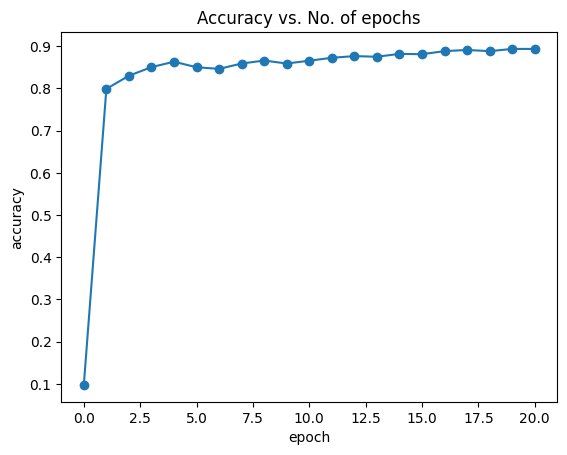

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. Of epochs');

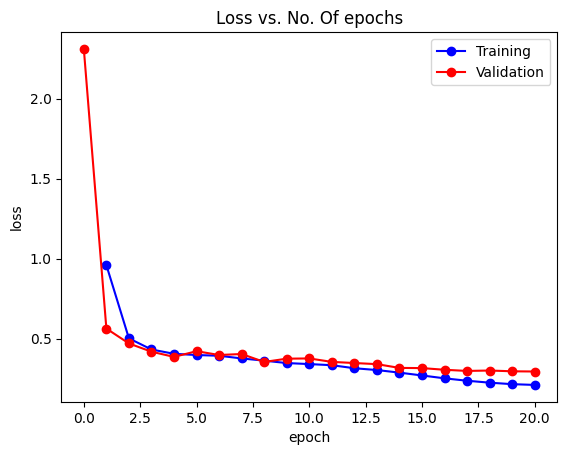

In [27]:
plot_losses(history)

## Testing with individual images

In [28]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,preds = torch.max(yb, dim = 1)
    label = preds[0].item()

    return test_dataset.classes[label]

Label : Ankle boot, predicted : Ankle boot


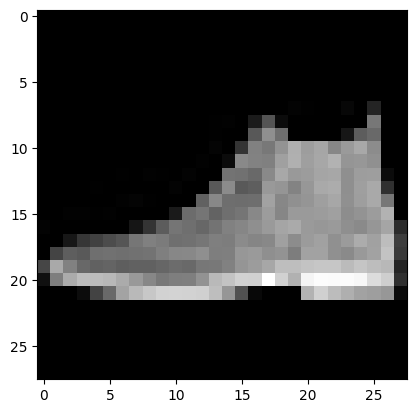

In [29]:
img, label = test_dataset[0]
plt.imshow(img[0],cmap='gray')
print(f'Label : {test_dataset.classes[label]}, predicted : {predict_image(img, model)}')

Label : Sneaker, predicted : Sneaker


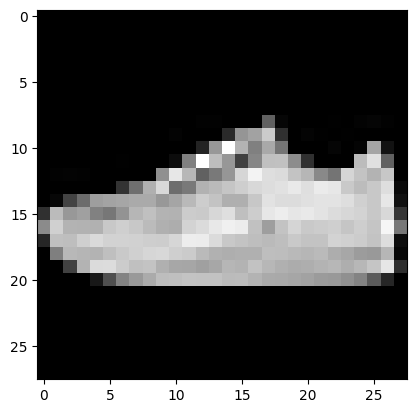

In [30]:
img, label = test_dataset[104]
plt.imshow(img[0],cmap='gray')
print(f'Label : {test_dataset.classes[label]}, predicted : {predict_image(img, model)}')

Overall loss and accuracy of model over test dataset

In [31]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256),device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.32450392842292786, 'val_acc': 0.88671875}

In [32]:
torch.save(model.state_dict(), 'models/fashion-mnist.pth')